# Class activation map evaluation

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
from pocovidnet.evaluate_covid19 import Evaluator
from pocovidnet.grad_cam import GradCAM
from pocovidnet.cam import get_class_activation_map
from pocovidnet.model import get_model

In [168]:
from skvideo import io

In [3]:
class VideoEvaluator(Evaluator):
    def __init__(self, weights_dir="../trained_models_cam", ensemble=True, split=None, model_id=None, num_classes=3):
        Evaluator.__init__(
            self, ensemble=ensemble, split=split, model_id=model_id, num_classes=num_classes
        )
    
    def __call__(self, video_path):
        """Performs a forward pass through the restored model

        Arguments:
            video_path: str -- file path to a video to process. Possibly types are mp4, gif, mpeg
            return_cams: int -- number of frames to return with activation maps overlayed. If zero, 
						only the predictions will be returned. Always selects the frames with 
                        highest probability for the predicted class

        Returns:
        	cams: if return_cams>0, images with overlay are returned as a np.array of shape
            		{number models} x {return_cams} x 224 x 224 x 3
            mean_preds: np array of shape {video length} x {number classes}. Contains
            			class probabilities per frame
        """

        self.image_arr = self.read_video(video_path)
        self.predictions = np.stack([model.predict(self.image_arr) for model in self.models])
        
        mean_preds = np.mean(self.predictions, axis=0, keepdims=False)
        class_idx = np.argmax(np.mean(np.array(mean_preds), axis=0))
        
        return mean_preds
    
    def cam_important_frames(self, class_idx, threshold=0.5, nr_cams=None, zeroing=0.65, save_video_path=None): # "out_video.mp4"):
        mean_preds = np.mean(self.predictions, axis=0, keepdims=False)
        # compute general video class
        # class_idx = np.argmax(np.mean(np.array(mean_preds), axis=0))
        prediction = np.argmax(np.mean(np.array(mean_preds), axis=0))
        print("predicted", prediction, "gt", class_idx)
        print("pred probs covid", [round(m, 2) for m in mean_preds[:,0]])
        # get most important frames (the ones above threshold)
        if nr_cams is not None:
            best_frames = np.argsort(mean_preds[:, class_idx])[-nr_cams:]
        else:
            best_frames = np.where(mean_preds[:, class_idx]>threshold)[0]
        # best_frames = np.arange(len(mean_preds))
        print("frames above threshold", best_frames)
        return_cams = len(best_frames)

        if len(best_frames)==0:
            print("no frame above threshold")
            return 0
            
        # copy image arr - need values between 0 and 255
        copied_arr = (self.image_arr.copy() * 255).astype(int)

        cams = np.zeros((return_cams, 224, 224, 3))
        for j, b_frame in enumerate(best_frames):
            # get highest prob model for these frames
            model_idx = np.argmax(self.predictions[:, b_frame, class_idx], axis=0)
            take_model = self.models[model_idx]
            if "cam" in self.model_id:
                in_img = np.expand_dims(self.image_arr[b_frame], 0)
                # print(in_img.shape)
                cams[j] = get_class_activation_map(take_model, in_img, class_idx, image_weight=1, zeroing=zeroing).astype(int)
            else:
                # run grad cam for other models
                gradcam = GradCAM()
                cams[j] = gradcam.explain(self.image_arr[b_frame], take_model, class_idx, return_map=False,image_weight=1, layer_name="block5_conv3", zeroing=zeroing, heatmap_weight=0.25)
                
        if save_video_path is None:
            return cams
        else:
            for j in range(return_cams):
                copied_arr[best_frames[j]] = cams[j]
            copied_arr = np.repeat(copied_arr, 3, axis=0)
            io.vwrite(save_video_path+".mpeg", copied_arr, outputdict={"-vcodec":"mpeg2video"})
        
    def read_video(self, video_path):
        assert os.path.exists(video_path), "video file not found"
        
        cap = cv2.VideoCapture(video_path)
        images = []
        counter = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if (ret != True):
                break
            if counter<1:
                plt.imshow(frame[30:360, 100:430]) # ICLUS: [70:570, 470:970]) # [25:350, 100:425]) # LOTTE:[30:400, 80:450]
                plt.show()
                counter += 1
                continue
            counter += 1
            img_processed = self.preprocess(frame)[0]
            images.append(img_processed)
        cap.release()
        return np.array(images)
    
    def preprocess(self, image, cut=True):
        """Apply image preprocessing pipeline

        Arguments:
            image {np.array} -- Arbitrary shape, quadratic preferred

        Returns:
            np.array -- Shape 224,224. Normalized to [0, 1].
        """
        if cut:
            image = image[30:360, 100:430]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = np.expand_dims(np.array(image), 0) / 255.0
        return image
    
    def important_frames(self, preds, predicted_class, n_return=5):
        preds_arr = np.array(preds)
        frame_scores = preds_arr[:, predicted_class]
        best_frames = np.argsort(frame_scores)[-n_return:]
        return best_frames

In [ ]:
evaluator = VideoEvaluator(ensemble=True, model_id="vgg_cam", num_classes=4)

### Run ICLUS data

In [18]:
def pred_plot(preds, save_path):
    plt.figure(figsize=(15,8))
    plt.plot(preds[:,0], label="covid")
    plt.plot(preds[:,1], label="pneu")
    plt.plot(preds[:,2], label="healthy")
    plt.legend()
    plt.savefig(save_path+".png")
    plt.show()
# plt.plot(preds[:,1], label="pneu")

In [29]:
# iclus_dir = "Videos_31_to_40"
iclus_dir = "test_data_regular/pat2"
# iclus_dir = "data/pocus_videos/convex/"
# out_iclus_data = "vids_preds_regular_test"
# out_iclus_data = "vids_preds_iclus"
out_iclus_data = "reg_test/pat2"
GT_CLASS = 2

In [ ]:
for vid in os.listdir(iclus_dir):
    vid_id = vid.split(".")[0]
    if vid.startswith(".") or os.path.exists(os.path.join(out_iclus_data,"cam_"+vid_id+".npy")):
        print("already done", vid)
        continue
    print("process next file ", vid)
    preds = evaluator(os.path.join(iclus_dir, vid))
    np.save(os.path.join(out_iclus_data,"cam_"+vid_id+".npy"), preds)
    plt.imshow(evaluator.image_arr[0])
    plt.savefig(os.path.join(out_iclus_data,"cam_"+vid_id+"expl_img.png"))
    print("saved predictions")
    pred_plot(preds, os.path.join(out_iclus_data,"cam_"+vid_id))
    print("saved plot")
    evaluator.cam_important_frames(GT_CLASS, save_video_path=os.path.join(out_iclus_data, "cam_"+vid_id))

#### ICLUS notes:

47 falsch predicted aber passt
schaut weird aus: 48, 49, 50 (linear or what is this? alle als healthy predicted)
Must do again: 36

13, 11, 31, 32: linear probes that are deleted, 22, 24, 26 (they are all kept), 28

12, 15, 16, 17, 18, 19, 20 were fine already with bad cropping
1, 3, 9, 10 is fine already

NEW PROCESSED: 14, 8, 7, 6, 4, 5, 2

CODE TO PROCESS SOME AGAIN:
if os.path.exists("vids_preds_iclus/cam_vid"+vid_id+".npy"):
    preds_prev = np.load("vids_preds_iclus/cam_vid"+vid_id+".npy")
    predicted_class = np.argmax(np.mean(np.array(preds_prev), axis=0))
    print(predicted_class, np.mean(np.array(preds_prev), axis=0))
    if predicted_class==0:
        print("file is already predicted covid", vid)
        continue

### Evaluate on train data

In [ ]:
vid_in_path = "/Users/ninawiedemann/Desktop/Projects/covid19_pocus_ultrasound.nosync/data/pocus_videos/Convex/"

In [ ]:
gt_dict = {"Cov":0, "Reg":2, "Pne":1, "pne":1}
out_path="vid_outputs_cam"
for vid in os.listdir(vid_in_path):
    if vid[:3] not in ["Pne", "pne", "Cov", "Reg"]:
        print(vid)
        continue
    if os.path.exists(os.path.join(out_path, vid.split(".")[0]+".mpeg")):
        print("already done", vid)
        continue
    vid_in = os.path.join(vid_in_path, vid)
    print(vid_in)
    preds = evaluator(vid_in)
    gt = gt_dict[vid[:3]]
    evaluator.cam_important_frames(gt, save_video_path=os.path.join(out_path, vid.split(".")[0]))

### Evaluate on test data

In [ ]:
out_path_overall="vid_outputs_cam_test/"
path_crossval = "../../data/cross_validation"
per_split = [[] for _ in range(5)]
for fold in range(5):
    out_path = os.path.join(out_path_overall, "fold"+str(fold))
    # load weights of the respective fold model
    print("NEW FOLD", fold)
    # make sure the variable is cleared
    evaluator = None
    # load weights
    evaluator = VideoEvaluator(ensemble=False, split=fold, model_id="vgg_cam", num_classes=4)
    # get all names belonging to this fold
    vidnames = []
    for mod in ["covid", "pneumonia", "regular"]:
        for f in os.listdir(os.path.join(path_crossval, "split"+str(fold), mod)):
            if f[0]!=".":
                fparts = f.split(".")
                vidnames.append(fparts[0]+"."+fparts[1][:3])
    # iterate over the relevant files
    names = np.unique(vidnames)
    for name in names:
        if name[-3:] in ["mp4", "mov", "gif"]:
            print(name)
            vid_in = os.path.join(vid_in_path, name)
            if not os.path.exists(vid_in):
                print("does not exist! - butterfly?", vid_in)
                continue
            if os.path.exists(os.path.join(out_path, name.split(".")[0]+".mpeg")):
                print("already done", name)
                continue
            print(vid_in)
            preds = evaluator(vid_in)
            gt = gt_dict[name[:3]]
            evaluator.cam_important_frames(gt, save_video_path=os.path.join(out_path, name.split(".")[0]))

## Make point plot for CAMs

In [37]:
def max_kernel(heatmap, kernel_size=9):
    k2 = kernel_size//2
    # pad array
    arr = np.pad(heatmap, ((k2,k2),(k2,k2)), 'constant', constant_values=0)
    # get coordinates of maximum
    x_coords, y_coords = divmod(np.argmax(arr.flatten()), len(arr[0]))   
    patch = arr[x_coords-k2:x_coords+k2+1, y_coords-k2:y_coords+k2+1]
    # print(x_coords, y_coords)
    # plt.imshow(arr)
    # plt.show()
    res_out = np.zeros((kernel_size-2,kernel_size-2))
    for i in range(kernel_size-2):
        for j in range(kernel_size-2):
            res_out[i,j] = np.mean(patch[i:i+3, j:j+3])
    max_x, max_y = divmod(np.argmax(res_out.flatten()), kernel_size-2)
    # print(max_x, max_y)
    # print(x_coords+max_x-k2+1, y_coords+max_y-k2+1)
    # plt.imshow(res_out)
    # plt.show()
    return x_coords+max_x-2*k2+1, y_coords+max_y-2*k2+1
# max_kernel((np.random.rand(10,10)*20).astype(int))

def convolve_faster(img, kernel):
    """
    Convolve a 2d img with a kernel, storing the output in the cell
    corresponding the the left or right upper corner
    :param img: 2d numpy array
    :param kernel: kernel (must have equal size and width)
    :param neg: if neg=0, store in upper left corner, if neg=1,
    store in upper right corner
    :return convolved image of same size
    """
    k_size = len(kernel)
    # a = np.pad(img, ((0, k_size-1), (0, k_size-1)))
    padded = np.pad(img, ((k_size//2, k_size//2), (k_size//2, k_size//2)))

    s = kernel.shape + tuple(np.subtract(padded.shape, kernel.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(padded, shape=s, strides=padded.strides * 2)
    return np.einsum('ij,ijkl->kl', kernel, subM)

# in_img = np.random.rand(20,20)
# plt.imshow(in_img)
# plt.show()
# out = convolve_faster(in_img, np.ones((7,7)))
# plt.imshow(out)
# plt.show()
# print(in_img.shape, out.shape)

### Process all test data

In [ ]:
path_crossval = "../../data/cross_validation"
gt_dict = {"Reg":2, "Pne":1, "pne":1, "Cov":0}

gradcam = GradCAM()

all_predictions = []
heatmap_points, predicted, gt_class, overlays, fnames = [], [], [], [], []

for fold in range(5):
    # load weights of the respective fold model
    print("NEW FOLD", fold)
    # make sure the variable is cleared
    evaluator = None
    # load weights
    evaluator = Evaluator(ensemble=False, split=fold, model_id="vgg_base", num_classes=4)
    # get all names belonging to this fold
    all_images_arr = []
    gt, name = [], []
    for mod in ["covid", "pneumonia", "regular"]:
        for f in os.listdir(os.path.join(path_crossval, "split"+str(fold), mod)):
            if f[0]!=".":
                # fparts = f.split(".")
                # vidnames.append(fparts[0]+"."+fparts[1][:3])
                img_loaded = cv2.imread(os.path.join(path_crossval, "split"+str(fold), mod, f))
                img_preprocc = evaluator.preprocess(img_loaded)[0]
                gt.append(gt_dict[f[:3]])
                all_images_arr.append(img_preprocc)
                name.append(f)
    all_images_arr = np.array(all_images_arr)
    # get predictions
    print("process all images in fold", fold, "with shape", all_images_arr.shape)
    fold_preds = evaluator.models[0].predict(all_images_arr)
    class_idx_per_img = np.argmax(fold_preds, axis=1)
    all_predictions.append(fold_preds)
    
    # get heatmap 
    for i, img in enumerate(all_images_arr):
        # plt.imshow(img)
        # plt.show()
        # overlay, heatmap = get_class_activation_map(evaluator.models[0], img, gt[i], image_weight=1, return_map=True, zeroing=0.65)
        overlay, heatmap = gradcam.explain(img, evaluator.models[0], gt[i], return_map=True, image_weight=1, layer_name="block5_conv3", zeroing=0.65, heatmap_weight=0.25)     
        # plt.figure(figsize=(10,10))
        # plt.imshow(overlay.astype(int))
        # plt.show()
        overlays.append(overlay.astype(int))
        # convolve with big kernel
        convolved_overlay = convolve_faster(heatmap, np.ones((19,19)))
        # print("previously:", divmod(np.argmax(heatmap.flatten()), len(heatmap[0])))
        x_coord, y_coord = divmod(np.argmax(convolved_overlay.flatten()), len(convolved_overlay[0]))
        ## previous version: 9x9 umkreis and 3x3 kernel
        # x_coord, y_coord = max_kernel(heatmap) # np.where(heatmap==np.max(heatmap))
        # print(x_coord, y_coord)
        heatmap_points.append([x_coord, y_coord])
        predicted.append(class_idx_per_img[i])
        gt_class.append(gt[i])
        fnames.append(name[i])
        # print([x_coord, y_coord], class_idx_per_img[i], gt[i])

In [40]:
len(predicted), len(gt_class), len(heatmap_points), np.asarray(overlays).shape

(1365, 1365, 1365, (1365, 224, 224, 3))

In [41]:
np.where(np.asarray(predicted)==3)

(array([730]),)

(1365, 2)


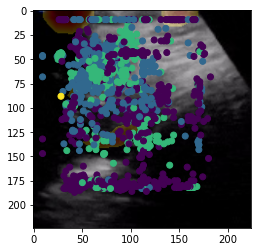

In [42]:
hm_p = np.array(heatmap_points)
print(hm_p.shape)
# plt.figure(figsize=(20,20))
plt.imshow(overlays[1])
plt.scatter(hm_p[:,1], hm_p[:,0], c=predicted)
plt.show()

No handles with labels found to put in legend.


(1365, 2)


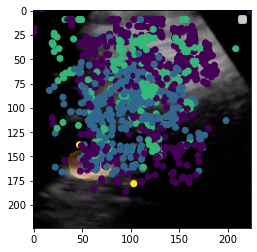

In [35]:
hm_p = np.array(heatmap_points)
print(hm_p.shape)
# plt.figure(figsize=(20,20))
plt.imshow(overlays[1])
plt.scatter(hm_p[:,1], hm_p[:,0], c=predicted)
plt.show()

In [43]:
df = pd.DataFrame()
df["file"] = fnames
df["predicted"] = predicted
df["gt"] = gt_class
df["max_x"] = np.asarray(heatmap_points)[:,0].tolist()
df["max_y"] = np.asarray(heatmap_points)[:,1].tolist()

In [44]:
df.to_csv("heatmap_points_grad.csv")

In [45]:
np.save("overlayed_hm.npy", overlays)

In [ ]:
df

## ICLUS evaluation

In [36]:
# out_iclus_data = "vids_preds_regular_test"
out_iclus_data = "vids_preds_iclus"

In [37]:
all_class_preds = []
correct_frames = 0
wrong_frames = 0
avg_corr_frames = []
all_frames = 0
# plt.figure(figsize=(20,10))
for f in os.listdir(out_iclus_data):
    if f[-3:]=="npy":
        preds = np.load(os.path.join(out_iclus_data, f))
        # plt.plot(preds[:,0])
        # print(preds.shape)
        # frame based
        frame_pred = np.argmax(preds, axis=1)
        all_frames += len(frame_pred)
        correct_frames += np.sum(frame_pred==0)
        wrong_frames += np.sum(frame_pred!=0)
        avg_corr_frames.append(np.sum(frame_pred==0)/len(frame_pred))
        # video classification - majority vote
        uni, counts = np.unique(frame_pred, return_counts=True)
        # all_class_preds.append(uni[np.argmax(counts)])
        # version with probabilities and not majority vote:
        vid_class_pred = np.argmax(np.mean(preds, axis=0))
        all_class_preds.append(vid_class_pred)
        if all_class_preds[-1]!=0:
            print("wrongly classified", f)
        
# print(wrong_frames+ correct_frames, all_frames)
print("Included in total ICLUS videos (without linear probes):", len(all_class_preds))
assert all_frames==wrong_frames+correct_frames
print("Frame accuracy:", correct_frames/float(all_frames))
print("video class accuracy (max avg probability): ", np.sum(np.array(all_class_preds)==0)/len(all_class_preds))
print("Mean and std of ratio of correctly classified frames per video:", np.mean(avg_corr_frames), np.std(avg_corr_frames))
# plt.show()

wrongly classified cam_vid57.npy
wrongly classified cam_vid47.npy
wrongly classified cam_vid52.npy
wrongly classified cam_vid35.npy
wrongly classified cam_vid6.npy
wrongly classified cam_vid7.npy
wrongly classified cam_vid25.npy
wrongly classified cam_vid39.npy
wrongly classified cam_vid58.npy
Included in total ICLUS videos (without linear probes): 40
Frame accuracy: 0.7422375554460325
video class accuracy (max avg probability):  0.775
Mean and std of ratio of correctly classified frames per video: 0.7145629363486894 0.3294651303703168


In [40]:
iclus_preds = all_class_preds

## Evaluation Lotte's test data

In [ ]:
reg_test_data = "vid_outputs_REGULAR"
all_class_preds = []
correct_frames = 0
wrong_frames = 0
avg_corr_frames = []
all_frames = 0
# plt.figure(figsize=(20,10))
for subdir in os.listdir(reg_test_data):
    if subdir[0]==".":
        continue
    print(subdir)
    for f in os.listdir(os.path.join(reg_test_data, subdir)):
        if f[-3:]=="npy":
            preds = np.load(os.path.join(reg_test_data, subdir, f))
            print(os.path.join(reg_test_data, subdir, f))
            # print(preds.shape)
            # frame based
            frame_pred = np.argmax(preds, axis=1)
            all_frames += len(frame_pred)
            correct_frames += np.sum(frame_pred==2)
            wrong_frames += np.sum(frame_pred!=2)
            avg_corr_frames.append(np.sum(frame_pred==2)/len(frame_pred))
            # video classification - majority vote
            
            vid_class_pred = np.argmax(np.mean(preds, axis=0))
            all_class_preds.append(vid_class_pred)
            # print(frame_pred)
            if all_class_preds[-1]!=2:
                print("wrongly classified", f)
            # version with probabilities and not majority vote:
            # vid_class_pred = np.argmax(np.mean(preds, axis=0))
            # all_class_preds.append(vid_class_pred)
# print(wrong_frames+ correct_frames, all_frames)
print("Included in total ICLUS videos (without linear probes):", len(all_class_preds))
assert all_frames==wrong_frames+correct_frames
print("Frame accuracy:", correct_frames/float(all_frames))
print("video class accuracy (max avg probability): ", np.sum(np.array(all_class_preds)==2)/len(all_class_preds))
print("Mean and std of ratio of correctly classified frames per video:", np.mean(avg_corr_frames), np.std(avg_corr_frames))
# plt.show()

In [43]:
reg_preds = all_class_preds

In [154]:
# sensitivity of both together
all_gt = np.asarray([1 for _ in range(len(iclus_preds))] + [0 for _ in range(len(reg_preds))])
all_preds = np.asarray(iclus_preds + reg_preds)
all_preds = np.absolute(all_preds/2 - 1).astype(int)
print(all_preds)
print(len(all_preds), len(all_gt))
print(recall_score(all_gt, all_preds))
print(precision_score(all_gt, all_preds))

[1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
66 66
0.775
0.9393939393939394


In [155]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

In [156]:
accuracy_score(all_gt, all_preds)

0.8333333333333334

## MD comments evaluation

### Read in and merge

In [7]:
mapping = pd.read_csv("mapping.csv").drop(columns=["Unnamed: 0"])

In [8]:
gb_comments = pd.read_csv("CAM_scores_GB.csv")
gb_comments = gb_comments.drop([0,1])
lotte_comments = pd.read_csv("CAM_scores_lotte.csv")

In [9]:
lotte_comments = lotte_comments.rename(columns={'Score - how helpful is the heatmap (0=only distracting, 5=very helpful)': 'lotte_score', 
                                                'Better one (put 1 if this one is the better one)': "lotte_better",
                                               'Class (Your guess)': 'lotte_class',
                                               'Patterns that can be seen':'lotte_patterns',
                                               'Patterns the heatmap highlights':'lotte_heatmap_patterns'}).drop(columns=["Unnamed: 6"])
gb_comments = gb_comments.rename(columns={'Score - how helpful is the heatmap (0=only distracting, 5=very helpful)': 'gb_score', 
                                                'Better one (put 1 if this one is the better one)': "gb_better",
                                               'Class (Your guess)': 'gb_class',
                                               'Patterns that can be seen':'gb_patterns',
                                               'Patterns the heatmap highlights':'gb_heatmap_patterns'})

In [10]:
lotte_comments['lotte_score'] = lotte_comments['lotte_score'].apply(lambda x: x-3 + int(x>=3))

In [11]:
merge_map_gb = pd.merge(mapping, gb_comments, how="inner", left_on="new_filename", right_on="Filename")
merge_map_lotte = pd.merge(merge_map_gb, lotte_comments, how="inner", left_on="new_filename", right_on="Filename")

In [112]:
merge_map_lotte.to_csv("CAM_scores_MDs.csv")

### Clean

In [52]:
final_table.columns

Index(['Unnamed: 0', 'previous_filename', 'new_filename', 'is_train', 'fold',
       'Filename_x', 'gb_score', 'gb_better', 'gb_class', 'gb_patterns',
       'gb_heatmap_patterns', 'Filename_y', 'lotte_score', 'lotte_better',
       'lotte_class', 'lotte_patterns', 'lotte_heatmap_patterns'],
      dtype='object')

In [53]:
# after manual cleaning:
final_table = pd.read_csv("CAM_scores_MDs.csv")

In [154]:
train_score_gb = 0
test_score_gb = 0
train_score_lo = 0
test_score_lo = 0
train_better_gb = []
train_better_lo = []
for group_name, group_df in final_table.groupby("previous_filename"):
    print("--------")
    print(group_df[["gb_better", "lotte_better", "is_train"]])
    if np.all(pd.isnull(group_df["gb_better"])) or len(np.where(group_df["gb_better"].values=="1")[0])==0:
        train_score_gb += 0.5
        test_score_gb += 0.5
        print("gb: equally good")
        train_better_gb.append(0.5)
    else:
        # if len(np.where(group_df["gb_better"].values=="1")[0])==0:
        #     raise RuntimeError("no valid value found")
        if np.where(group_df["gb_better"].values=="1")==np.where(group_df["is_train"].values==1):
            print("gb: train better")
            train_score_gb += 1
            train_better_gb.append(1)
        else:
            test_score_gb += 1
            train_better_gb.append(0)
            print("gb: test better")
    # get lotte score
    if np.all(pd.isnull(group_df["lotte_better"])):
        train_score_gb += 0.5
        test_score_gb += 0.5
        train_better_lo.append(0.5)
        print("lotte: equally good")
    else:
        if len(np.where(group_df["lotte_better"].values==1)[0])==0:
            raise RuntimeError("no valid value found")
        if np.where(group_df["lotte_better"].values==1)==np.where(group_df["is_train"].values==1):
            print("lotte: train better")
            train_score_lo += 1
            train_better_lo.append(1)
        else:
            test_score_lo += 1
            train_better_lo.append(0)
            print("lotte: test better")
    
    for i, row in group_df.iterrows():
        if int(row["is_train"])==1:
            print(row["gb_better"], row["lotte_better"], row["is_train"])
    # gb_scores = group_df["gb_better"]
    # lotte_scores = group_df["lotte_better"]
    # train_test = group_df["is_train"]
    

--------
   gb_better  lotte_better  is_train
72       NaN           0.0         1
73         1           1.0         0
gb: test better
lotte: test better
nan 0.0 1
--------
   gb_better  lotte_better  is_train
80       NaN           0.0         1
81         1           1.0         0
gb: test better
lotte: test better
nan 0.0 1
--------
   gb_better  lotte_better  is_train
66       NaN           1.0         1
67       NaN           0.0         0
gb: equally good
lotte: train better
nan 1.0 1
--------
   gb_better  lotte_better  is_train
20       NaN           NaN         1
21       NaN           NaN         0
gb: equally good
lotte: equally good
nan nan 1
--------
  gb_better  lotte_better  is_train
6       NaN           0.0         1
7         1           1.0         0
gb: test better
lotte: test better
nan 0.0 1
--------
   gb_better  lotte_better  is_train
32       NaN           0.0         1
33         1           1.0         0
gb: test better
lotte: test better
nan 0.0 1
--------


In [156]:
len(train_better_lo), len(train_better_gb)

(49, 49)

In [163]:
better_arr = np.swapaxes(np.stack([train_better_lo, train_better_gb]), 1, 0)

In [173]:
agree = np.sum(better_arr[:,0]==better_arr[:,1])
print("agreement (both exactly same)", agree/len(better_arr))
print("disagreement (one 1 one 0)", len(np.where(np.absolute(better_arr[:,0]-better_arr[:,1])==1)[0])/len(better_arr))

agreement (both exactly same) 0.7142857142857143
disagreement (one 1 one 0) 0.08163265306122448


In [180]:
print("average score for train better:", np.mean(train_better_lo), np.mean(train_better_gb))

average score for train better: 0.4387755102040816 0.4387755102040816


In [182]:
print("numbers unique",np.unique(train_better_lo, return_counts=True), np.unique(train_better_gb, return_counts=True))

numbers unique (array([0. , 0.5, 1. ]), array([20, 15, 14])) (array([0. , 0.5, 1. ]), array([16, 23, 10]))


#### Evaluate scores - Add label

In [69]:
label = [val[:3].lower() for val in final_table["previous_filename"].values]

In [16]:
np.unique(label, return_counts=True)

(array(['cov', 'pne', 'reg'], dtype='<U3'), array([28, 42, 28]))

In [22]:
np.mean(final_table[final_table["is_train"]==0]["gb_score"])

1.0612244897959184

In [70]:
final_table["label"] = label

#### Get average score of Lotte and Gabriel together

In [71]:
only_test = final_table[final_table["is_train"]==0]
all_scores = only_test["gb_score"].values.tolist() + only_test["lotte_score"].values.tolist()
print("Mean score lotte and gabriel together (test):", np.mean(all_scores))
# other method: average per video scores first:
mean_scores = 0.5* (only_test["gb_score"].values + only_test["lotte_score"].values)
print("Mean score lotte and gabriel together (test) - other method:", np.mean(mean_scores))
print(np.vstack([only_test["gb_score"].values, only_test["lotte_score"].values]))

Mean score lotte and gabriel together (test): 0.8061224489795918
Mean score lotte and gabriel together (test) - other method: 0.8061224489795918
[[ 1.  2.  3.  2.  3. -3.  3.  3.  3.  3. -3.  3.  2. -3.  2.  1.  2.  3.
   3.  1.  1.  2.  3.  1.  1. -3.  3.  3. -2. -3. -3.  2.  3. -3. -3.  3.
   2.  3. -2.  2.  0. -2.  0.  3.  3.  2. -1.  3.  3.]
 [-2.  1.  3.  3. -3.  1.  2.  2.  3.  3. -3.  3. -1. -3.  2. -1.  2.  3.
   2.  1. -3.  1.  2.  2.  2. -1.  3. -1. -2. -3. -3.  1.  3. -3. -1.  3.
   1.  3. -2.  2. -1. -2. -3.  2.  3. -1.  1.  3.  3.]]


In [72]:
only_test["mean_scores"] = mean_scores.tolist()

/Users/ninawiedemann/miniconda3/envs/covid_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
only_test.groupby("label").agg({"mean_scores":"mean"})

,mean_scores
label,
cov,-0.250000
pne,2.047619
reg,0.000000


#### Test whether test better train significant

In [148]:
from scipy.stats import ttest_ind, ttest_rel, wilcoxon, mannwhitneyu

In [149]:
only_train = final_table[final_table["is_train"]==1]
all_train_scores = only_train["gb_score"].values.tolist() + only_train["lotte_score"].values.tolist()
only_test = final_table[final_table["is_train"]==0]
all_test_scores = only_test["gb_score"].values.tolist() + only_test["lotte_score"].values.tolist()
print("means", np.mean(all_train_scores), np.mean(all_test_scores))

print("Ttest ind:", ttest_ind(all_train_scores,all_test_scores, equal_var=False))
print("ttest related:", ttest_rel(all_train_scores,all_test_scores))
print("Wilcoxon:", wilcoxon(all_train_scores,all_test_scores))
print("mannwhitneyu", mannwhitneyu(all_train_scores,all_test_scores))
# Ttest related
# Examples for use are scores of the same set of student in different exams, 
# or repeated sampling from the same units. The test measures whether the average score
# differs significantly across samples (e.g. exams). If we observe a large p-value, for
# example greater than 0.05 or 0.1 then we cannot reject the null hypothesis of identical average scores

means 0.4489795918367347 0.8061224489795918
Ttest ind: Ttest_indResult(statistic=-1.0472478430018906, pvalue=0.29630137692353337)
ttest related: Ttest_relResult(statistic=-1.4949993449746575, pvalue=0.13816089597627726)
Wilcoxon: WilcoxonResult(statistic=488.0, pvalue=0.1466480804322432)
mannwhitneyu MannwhitneyuResult(statistic=4518.5, pvalue=0.23196542826128874)


98 98


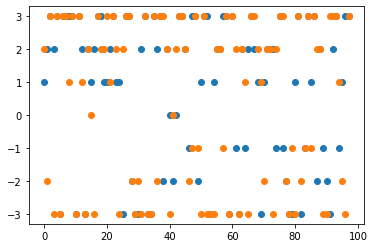

In [82]:
print(len(all_train_scores), len(all_test_scores))
plt.scatter(range(len(all_test_scores)), all_test_scores)
plt.scatter(range(len(all_train_scores)), all_train_scores)

#### Grouped for separate scores

In [194]:

only_test = final_table[final_table["is_train"]==0]
grouped = only_test.groupby("label").agg({"lotte_score":"mean", "gb_score":"mean"})
grouped

,lotte_score,gb_score
label,,
cov,-0.214286,-0.285714
pne,1.666667,2.428571
reg,-0.357143,0.357143


In [92]:
only_test = only_test.fillna("none")

In [209]:
gb_all_with_consolidations = only_test[only_test["gb_patterns"].str.contains("onsolida")]
print("number of videos with consolidations", len(gb_all_with_consolidations))
print("GB heatmap highlights consolidation", len(gb_all_with_consolidations[gb_all_with_consolidations["gb_heatmap_patterns"].str.contains("onsolida")]))
print("Lotte heatmap highlights consolidation", len(gb_all_with_consolidations[gb_all_with_consolidations["lotte_heatmap_patterns"].str.contains("onsolida")]))


number of videos with consolidations 18
Note: observed that both MDs agreed here
GB heatmap highlights consolidation 17
Lotte heatmap highlights consolidation 17


In [213]:
gb_all_with_alines = only_test[only_test["gb_patterns"].str.contains("A")]
print("number of videos with A lines", len(gb_all_with_alines))
print("GB heatmap highlights A lines", len(gb_all_with_alines[gb_all_with_alines["gb_heatmap_patterns"].str.contains("A")]))
print("Lotte heatmap highlights A lines", len(gb_all_with_alines[gb_all_with_alines["lotte_heatmap_patterns"].str.contains("A")]))


number of videos with A lines 13
Note: observed that both MDs agreed here
GB heatmap highlights A lines 6
Lotte heatmap highlights A lines 10


In [216]:
gb_all_with_blines = only_test[only_test["gb_patterns"].str.contains("B")]
print("number of videos with B lines", len(gb_all_with_blines))
print("GB heatmap highlights B lines", len(gb_all_with_blines[gb_all_with_blines["gb_heatmap_patterns"].str.contains("B")]))
print("Lotte heatmap highlights B lines", len(gb_all_with_blines[gb_all_with_blines["lotte_heatmap_patterns"].str.contains("B")]))
print("Note: Lotte usually writes that it catches ONE bline in the video, or beginning of bline")

number of videos with B lines 18
GB heatmap highlights B lines 0
Lotte heatmap highlights B lines 7
Note: Lotte usually writes that it catches ONE bline in the video, or beginning of bline


In [120]:
class_wise = []
for pattern in ["onsol", "B", "A"]:
    print("--------", pattern)
    gb_all_with_pattern = only_test[only_test["gb_patterns"].str.contains(pattern)]
    for classe in ["cov", "pne", "reg"]:
        class_filtered = gb_all_with_pattern[gb_all_with_pattern["label"]==classe]
        print(classe, pattern, len(class_filtered))
        # gb_all_with_pattern = class_filtered[class_filtered["gb_patterns"].str.contains(pattern)]
        number_found = 0.5*(len(class_filtered[class_filtered["gb_heatmap_patterns"].str.contains(pattern)])
        + len(class_filtered[class_filtered["lotte_heatmap_patterns"].str.contains(pattern)]))
        if len(class_filtered)>0:
            print(classe, number_found/len(class_filtered))
        
# print(gb_all_with_pattern["label"])

-------- onsol
cov onsol 1
cov 1.0
pne onsol 17
pne 0.9411764705882353
reg onsol 0
-------- B
cov B 10
cov 0.3
pne B 1
pne 0.0
reg B 1
reg 0.0
-------- A
cov A 1
cov 0.0
pne A 0
reg A 12
reg 0.6666666666666666


In [117]:
from matplotlib import rc
rc('text', usetex=False)

No handles with labels found to put in legend.


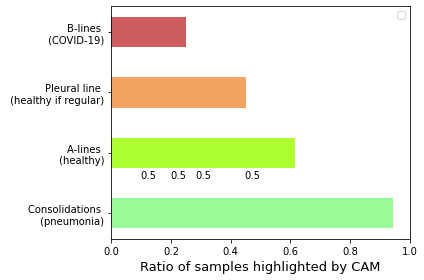

In [153]:
fig, ax = plt.subplots()
rects = ax.barh(["Consolidations \n (pneumonia)", "A-lines \n (healthy)", "Pleural line \n (healthy if regular)", "B-lines \n (COVID-19)"], [17/18, 8/13, 9/20, 3/12], width
        , color = ["palegreen","greenyellow","sandybrown", "indianred"])
ax.set_xlim(0,1)

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.set_yticks(["Consolidations \n (pneumonia)", "A-lines \n (healthy)", "Pleural line \n (healthy if regular)", "B-lines \n (COVID-19)"], fontsize=13)
ax.set_xlabel("Ratio of samples highlighted by CAM", fontsize=13)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects)
fig.tight_layout()

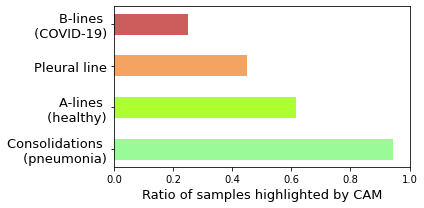

In [164]:
plt.figure(figsize=(6,3))
width=0.5
plt.barh(["Consolidations \n (pneumonia)", "A-lines \n (healthy)", "Pleural line", "B-lines \n (COVID-19)"], [17/18, 8/13, 9/20, 3/12], width
        , color = ["palegreen","greenyellow","sandybrown", "indianred"])
plt.xlim(0,1)
plt.yticks(fontsize=13)
plt.xlabel("Ratio of samples highlighted by CAM", fontsize=13)
plt.tight_layout()
plt.savefig("barplot_cam.pdf")

In [227]:
print("FROM GABRIELS PATTERNS:")
for pattern in ["onsolida", "A", "B", "ronchogram", "ffusion"]:
    print("-------------------")
    gb_all_with_pattern = only_test[only_test["gb_patterns"].str.contains(pattern)]
    print("number of videos with ", pattern, len(gb_all_with_pattern))
    print("GB heatmap highlights ", pattern, len(gb_all_with_pattern[gb_all_with_pattern["gb_heatmap_patterns"].str.contains(pattern)]))
    print("Lotte heatmap highlights ", pattern, len(gb_all_with_pattern[gb_all_with_pattern["lotte_heatmap_patterns"].str.contains(pattern)]))
print("---------------")
print("Note: observed that both MDs agreed where consolidations are found")
print("Note: Lotte usually writes that it catches ONE bline in the video, or beginning of bline")

FROM GABRIELS PATTERNS:
-------------------
number of videos with  onsolida 18
GB heatmap highlights  onsolida 17
Lotte heatmap highlights  onsolida 17
-------------------
number of videos with  A 13
GB heatmap highlights  A 6
Lotte heatmap highlights  A 10
-------------------
number of videos with  B 12
GB heatmap highlights  B 0
Lotte heatmap highlights  B 6
-------------------
number of videos with  ronchogram 2
GB heatmap highlights  ronchogram 2
Lotte heatmap highlights  ronchogram 0
-------------------
number of videos with  ffusion 7
GB heatmap highlights  ffusion 1
Lotte heatmap highlights  ffusion 0
---------------
Note: observed that both MDs agreed where consolidations are found
Note: Lotte usually writes that it catches ONE bline in the video, or beginning of bline


In [229]:
print("FROM LOTTES PATTERNS:")
for pattern in ["onsolida", "A", "B", "ffusion", "leura"]:
    print("-------------------")
    gb_all_with_pattern = only_test[only_test["lotte_patterns"].str.contains(pattern)]
    print("number of videos with ", pattern, len(gb_all_with_pattern))
    print("GB heatmap highlights ", pattern, len(gb_all_with_pattern[gb_all_with_pattern["gb_heatmap_patterns"].str.contains(pattern)]))
    print("Lotte heatmap highlights ", pattern, len(gb_all_with_pattern[gb_all_with_pattern["lotte_heatmap_patterns"].str.contains(pattern)]))
print("---------------")
print("Note: observed that both MDs agreed where consolidations are found")
print("Note: Lotte usually writes that it catches ONE bline in the video, or beginning of bline")

FROM LOTTES PATTERNS:
-------------------
number of videos with  onsolida 22
GB heatmap highlights  onsolida 21
Lotte heatmap highlights  onsolida 21
-------------------
number of videos with  A 17
GB heatmap highlights  A 6
Lotte heatmap highlights  A 12
-------------------
number of videos with  B 18
GB heatmap highlights  B 0
Lotte heatmap highlights  B 7
-------------------
number of videos with  ffusion 3
GB heatmap highlights  ffusion 1
Lotte heatmap highlights  ffusion 0
-------------------
number of videos with  leura 20
GB heatmap highlights  leura 3
Lotte heatmap highlights  leura 9
---------------
Note: observed that both MDs agreed where consolidations are found
Note: Lotte usually writes that it catches ONE bline in the video, or beginning of bline


In [234]:
print("overall number of videos", len(only_test))
for name in ["gb", "lotte"]:
    print("---------- "+name+" --------------")
    for pattern in ["uscle", "fat", "skin"]:
        print(pattern, np.sum(only_test[name+"_heatmap_patterns"].str.contains(pattern)))

overall number of videos 49
---------- gb --------------
uscle 13
fat 13
skin 3
---------- lotte --------------
uscle 13
fat 3
skin 0


#### Notes:

GB: 1 time "Avoids the liver, I'm impressed, but several times "tricked by the liver"

## Backups

## Test gradcam

In [ ]:
normal_eval = Evaluator(ensemble=False, split=0) # , model_id="")

In [ ]:
vid_in = vid_in_path + "Pneu_liftl_pneu_case3_clip5.mp4"

In [ ]:
img = cv2.imread("/Users/ninawiedemann/Desktop/Projects/covid19_pocus_ultrasound.nosync/data/my_found_data/Cov_efsumb1_2.png")
img = cv2.imread("/Users/ninawiedemann/Desktop/Projects/covid19_pocus_ultrasound.nosync/data/pocus_images/convex/Cov_blines_covidmanifestation_paper2.png")


In [ ]:
img = evaluator.preprocess(img)

In [ ]:
grad = GradCAM()
out_map = grad.explain(img[0], evaluator.models[0], 0, return_map=False, layer_name="block5_conv3", zeroing=0.6)

In [ ]:
plt.imshow(out_map.astype(int))

In [ ]:
out_cam = get_class_activation_map(evaluator.models[0], img, 1, heatmap_weight=0.1, zeroing=0.8)

### Check cross val

In [157]:
check = "/Users/ninawiedemann/Desktop/Projects/covid19_pocus_ultrasound.nosync/data/cross_validation"
file_list = []
for folder in os.listdir(check):
    if folder[0]==".":
        continue
    for classe in os.listdir(os.path.join(check, folder)):
        if classe[0]==".": # or classe[0]=="u":
            continue
        uni = []
        is_image = 0
        for file in os.listdir(os.path.join(check, folder, classe)):
            if file[0]==".":
                continue
            if len(file.split("."))==2:
                is_image+=1
            file_list.append(file)
            uni.append(file.split(".")[0])
            # assert file[:3].lower()==classe[:3], "wrong label"+file[:3]+classe[:3]
        print(folder, classe, len(np.unique(uni)), len(uni), is_image)
assert len(file_list)==len(np.unique(file_list))
print(len(file_list))

split4 pneumonia 7 41 2
split4 regular 5 46 1
split4 covid 11 171 3
split3 pneumonia 8 99 2
split3 regular 5 90 1
split3 covid 11 187 3
split2 pneumonia 5 63 1
split2 regular 5 60 1
split2 covid 10 121 3
split0 pneumonia 5 79 1
split0 regular 5 72 1
split0 covid 11 105 4
split1 pneumonia 6 95 1
split1 regular 5 64 1
split1 covid 10 110 3
1403


## Copy from train and test folders, give new ideas, and construct mapping

In [ ]:
testcam = "vid_outputs_cam_test"
files_to_process = []
for subdir in os.listdir(testcam):
    if subdir[0]=="." or subdir=="not taken" :
        continue
    for f in os.listdir(os.path.join(testcam, subdir)):
        if f[0]==".":
            continue
        
        if not os.path.exists(os.path.join("vid_outputs_cam", f)):
            print("does not exist in train", subdir, f)
            # if not "RUQ" in f:
             #   todo.append(f.split(".")[0])
        else:
            files_to_process.append(os.path.join(subdir, f))
# print(todo)

In [ ]:
# code to copy files to randomized thing
import shutil

In [ ]:
drop_cams_dir = "vids_to_check"
test_cam_dir = "vid_outputs_cam_test"
train_cam_dir = "vid_outputs_cam"
# create directory
if not os.path.exists(drop_cams_dir):
    os.makedirs(drop_cams_dir)
# give random ids
ids = np.random.permutation(len(files_to_process))

# define dataframe columns
new_fname = []
old_fname = []
is_train = []
fold = []
for i, f_name_path in enumerate(files_to_process):
    split_name, f_name = tuple(f_name_path.split(os.sep))
    split = int(split_name[-1])
    # randomly add to model2
    out_f_name = "video_"+str(ids[i])+"_model_"
    old_fname.append(f_name)
    old_fname.append(f_name)
    rand_folder_train = np.random.rand()<0.5
    print("train gets 1?", rand_folder_train)
    
    # copy train data
    train_outfname = out_f_name + str(int(rand_folder_train)) + ".mpeg"
    train_to_path = os.path.join(drop_cams_dir, train_outfname)
    cp_from_path = os.path.join(train_cam_dir, f_name)
    # append for df
    is_train.append(1)
    fold.append(split)
    new_fname.append(train_outfname)
    print("TRAIN:", cp_from_path, train_to_path)
    shutil.copy(cp_from_path, train_to_path)
    
    # copy test 
    test_outfname = out_f_name + str(int(not rand_folder_train)) + ".mpeg"
    test_to_path = os.path.join(drop_cams_dir, test_outfname)
    cp_from_path = os.path.join(test_cam_dir, split_name, f_name)
    # append for df
    fold.append(split)
    is_train.append(0)
    new_fname.append(test_outfname)
    print("TEST:", cp_from_path, test_to_path)
    shutil.copy(cp_from_path, test_to_path)

In [ ]:
df = pd.DataFrame()
df["previous_filename"] = old_fname
df["new_filename"] = new_fname
df["is_train"] = is_train
df["fold"] = fold
df.head(30)

In [ ]:
df.to_csv(drop_cams_dir+"/mapping.csv")

In [7]:
iclus_dir = "test_data_regular/pat1"
# out_path = "iclus_videos_processed"

In [ ]:
FRAMERATE = 3
MAX_FRAMES = 30

for fn in os.listdir(iclus_dir):
    if fn[0]==".":
        continue
    cap = cv2.VideoCapture(os.path.join(iclus_dir, fn))
    n_frames = cap.get(7)
    frameRate = cap.get(5)
    nr_selected = 0
    every_x_image = int(frameRate / FRAMERATE)
    while cap.isOpened() and nr_selected < MAX_FRAMES:
        ret, frame = cap.read()
        if (ret != True):
            break
        print(cap.get(1), cap.get(2), cap.get(3), cap.get(4), cap.get(5), cap.get(6), cap.get(7))
        h, w, _ = frame.shape
        # print(h,w)
        plt.imshow(frame[30:400, 80:450])
        plt.show()
        # SAVE
       # if ((frameId+1) % every_x_image == 0):
       #     # storing the frames in a new folder named test_1
       #     filename = out_path + fn + "_frame%d.jpg" % frameId
       #     cv2.imwrite(filename, frame)
       #     nr_selected += 1
       #     print(frameId, nr_selected)
    cap.release()

In [163]:
import shutil
check = "/Users/ninawiedemann/Desktop/Projects/covid19_pocus_ultrasound.nosync/data/cross_validation_segmented"
out = "../../data/cross_validation_segmented_new"
for folder in os.listdir(check):
    if folder[0]==".":
        continue
    os.makedirs(os.path.join(out, folder))
    for classe in os.listdir(os.path.join(check, folder)):
        os.makedirs(os.path.join(out, folder, classe))
        if classe[0]==".": # or classe[0]=="u":
            continue
        for f in os.listdir(os.path.join(check, folder, classe)):
            if f[-3:]=="gif":
                shutil.copy(os.path.join(check, folder, classe, f), os.path.join(out, folder, classe, f[:-4]))
            elif f[-3:] =="npz":
                shutil.copy(os.path.join(check, folder, classe, f), os.path.join(out, folder, classe, f))

### Cut Lotte's videos

In [184]:
file_list = ["pat1Image_132943.mpeg",
"pat1Image_133043.mpeg",
"pat1Image_133138.mpeg",
"pat1Image_133232.mpeg",
"pat1Image_133327.mpeg",
"pat1Image_133410.mpeg",
"pat2Image_133824.mpeg",
"pat2Image_133952.mpeg",
"pat2Image_134138.mpeg",
"pat2Image_134240.mpeg",
"pat2Image_134348.mpeg",
"pat2Image_134441.mpeg",
"pat3Image_134711.mpeg",
"pat3Image_134811.mpeg",
"pat3Image_134904.mpeg",
"pat3Image_135026.mpeg",
"pat3Image_135128.mpeg",
"pat3Image_135215.mpeg",
"pat4Image_135904.mpeg",
"pat4Image_140024.mpeg",
"pat4Image_140238.mpeg",
"pat4Image_140434.mpeg",
"pat4Image_140606.mpeg",
"pat4Image_140705.mpeg"]
copy_path = "../../data/pocus_videos/convex/"
for f in file_list:
    video_path = "reg_propro/"+f
    # cap = cv2.VideoCapture(video_path)
    # print(cap.get(7))
    # cap.release()
    print("Reg_"+f)
    shutil.copy(video_path, copy_path+"Reg_"+f)

Reg_pat1Image_132943.mpeg
Reg_pat1Image_133043.mpeg
Reg_pat1Image_133138.mpeg
Reg_pat1Image_133232.mpeg
Reg_pat1Image_133327.mpeg
Reg_pat1Image_133410.mpeg
Reg_pat2Image_133824.mpeg
Reg_pat2Image_133952.mpeg
Reg_pat2Image_134138.mpeg
Reg_pat2Image_134240.mpeg
Reg_pat2Image_134348.mpeg
Reg_pat2Image_134441.mpeg
Reg_pat3Image_134711.mpeg
Reg_pat3Image_134811.mpeg
Reg_pat3Image_134904.mpeg
Reg_pat3Image_135026.mpeg
Reg_pat3Image_135128.mpeg
Reg_pat3Image_135215.mpeg
Reg_pat4Image_135904.mpeg
Reg_pat4Image_140024.mpeg
Reg_pat4Image_140238.mpeg
Reg_pat4Image_140434.mpeg
Reg_pat4Image_140606.mpeg
Reg_pat4Image_140705.mpeg


In [ ]:
out_dir = "reg_propro/pat4"
in_dir =  "test_data_regular/pat4"
for vid in os.listdir(in_dir):
    if vid[0]==".":
        continue
    video_path = os.path.join(in_dir, vid)
    cap = cv2.VideoCapture(video_path)
    images = []
    counter = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if (ret != True):
            break
        if counter<1:
            plt.imshow(frame[30:400, 80:450]) # ICLUS: [70:570, 470:970]) # [25:350, 100:425]) # LOTTE:[30:400, 80:450]
            plt.show()
            counter += 1
            continue
        counter += 1
        img_processed = frame[30:400, 80:450]
        images.append(img_processed)
    cap.release()
    
    images = np.asarray(images)
    print(images.shape)
    io.vwrite(out_dir+ vid.split(".")[0]+".mpeg", images, outputdict={"-vcodec":"mpeg2video"})